In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/.virtual_documents/__notebook_source__.ipynb


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


In [11]:
import os

dataset_path = '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data'

train_dir = os.path.join(dataset_path, 'train')
val_dir   = os.path.join(dataset_path, 'val')


In [12]:
import warnings
warnings.filterwarnings('ignore')


In [13]:


dataset_path = '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data'
# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{dataset_path}/train",
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),  # Resize to 224x224
    batch_size=32,
    shuffle=True
)


Found 34792 files belonging to 5 classes.


I0000 00:00:1765777623.259242      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{dataset_path}/val",
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 9940 files belonging to 5 classes.


In [15]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

raw_train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 34792 files belonging to 5 classes.


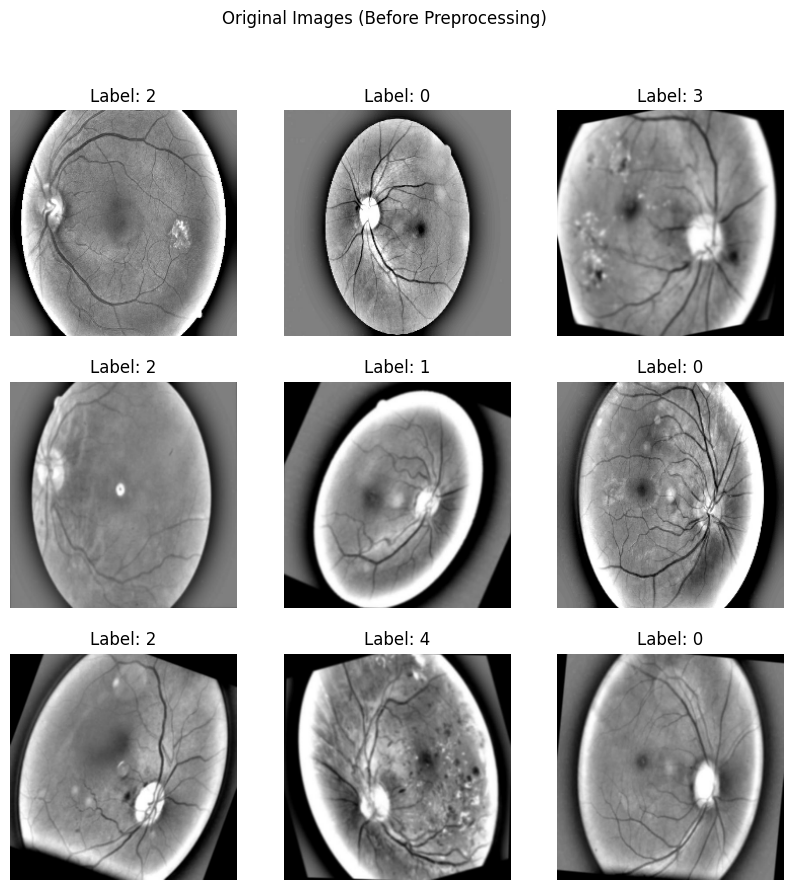

In [16]:
plt.figure(figsize=(10,10))

for images, labels in raw_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

plt.suptitle("Original Images (Before Preprocessing)")
plt.show()


In [18]:
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds = raw_train_ds.map(
    lambda x, y: (normalization_layer(x), y)
)


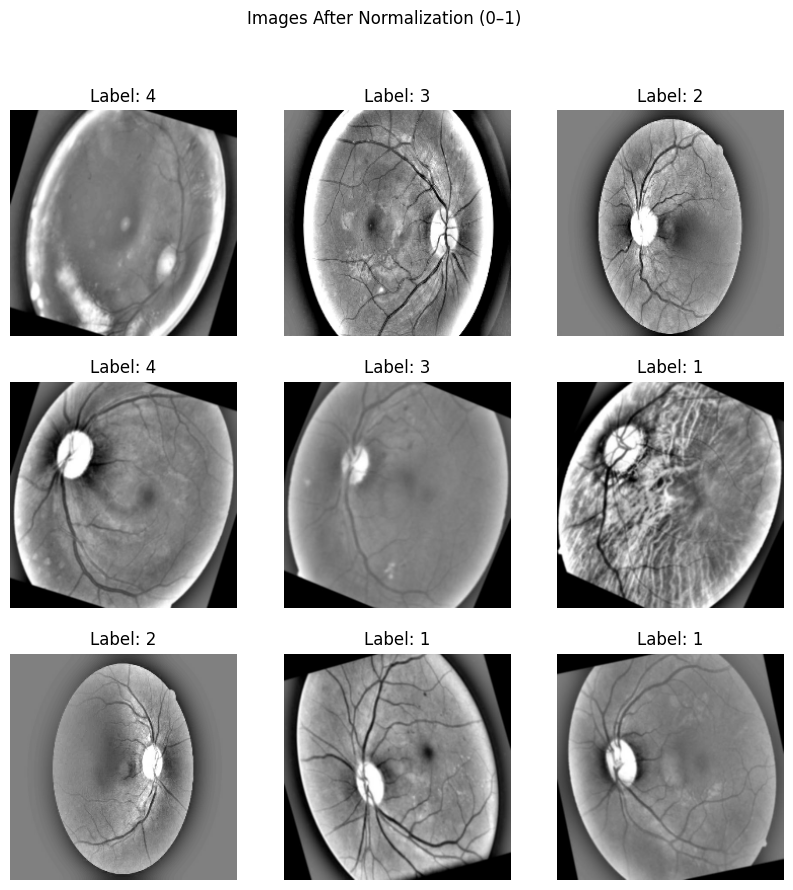

In [19]:
plt.figure(figsize=(10,10))

for images, labels in normalized_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

plt.suptitle("Images After Normalization (0–1)")
plt.show()


In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [21]:
augmented_train_ds = normalized_train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


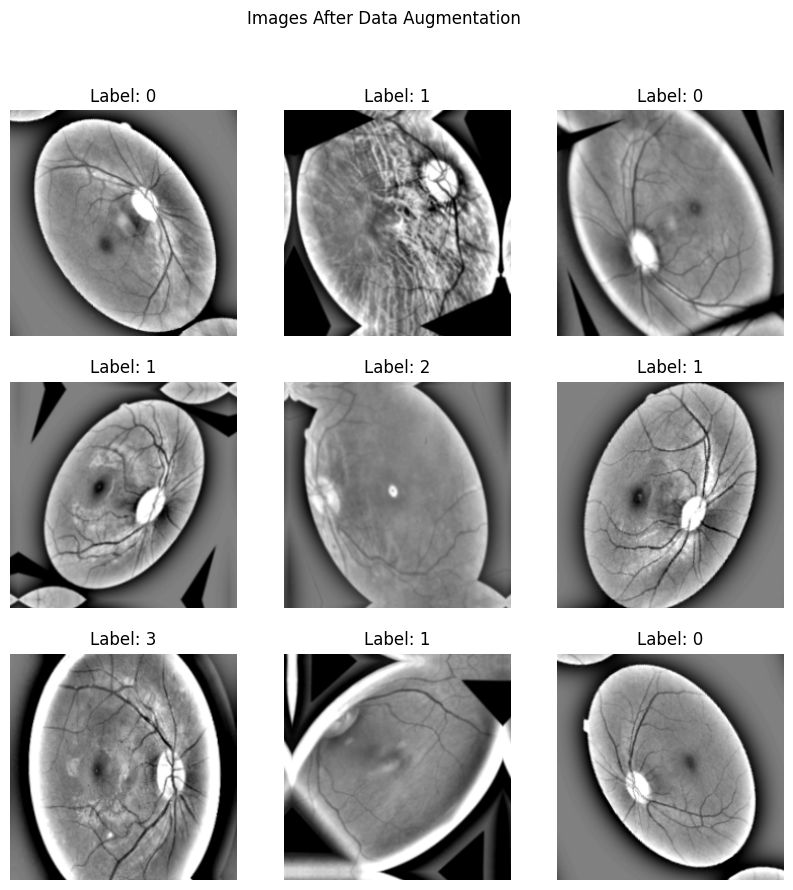

In [22]:
plt.figure(figsize=(10,10))

for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

plt.suptitle("Images After Data Augmentation")
plt.show()


In [24]:
import os
from collections import Counter

def count_images(directory):
    counter = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counter[class_name] = len(os.listdir(class_path))
    return counter

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)

print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)


Train class distribution: Counter({'2': 7000, '0': 7000, '3': 7000, '4': 7000, '1': 6792})
Validation class distribution: Counter({'2': 2000, '0': 2000, '3': 2000, '4': 2000, '1': 1940})


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = augmented_train_ds.prefetch(AUTOTUNE)
val_ds   = val_dataset.prefetch(AUTOTUNE)


In [26]:
from tensorflow.keras import layers, models

NUM_CLASSES = 5

def build_cnn(dropout_rate=0.4, learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1
)


In [28]:
model = build_cnn()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30


I0000 00:00:1765777715.628538     119 service.cc:148] XLA service 0x7be9d8001e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765777715.629928     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765777716.226595     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2175 ━━━━━━━━━━━━━━━━━━━━ 5:24:42 9s/step - accuracy: 0.1875 - loss: 2.6235

I0000 00:00:1765777721.176417     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 437s 197ms/step - accuracy: 0.3393 - loss: 1.6238 - val_accuracy: 0.2119 - val_loss: 250.0992 - learning_rate: 0.0010
Epoch 2/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 401s 184ms/step - accuracy: 0.4375 - loss: 1.2716 - val_accuracy: 0.2015 - val_loss: 628.1895 - learning_rate: 0.0010
Epoch 3/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 401s 184ms/step - accuracy: 0.4739 - loss: 1.1977 - val_accuracy: 0.2029 - val_loss: 367.8604 - learning_rate: 0.0010
Epoch 4/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4993 - loss: 1.1526
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 399s 183ms/step - accuracy: 0.4993 - loss: 1.1526 - val_accuracy: 0.3125 - val_loss: 328.4211 - learning_rate: 0.0010
Epoch 5/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 392s 180ms/step - accuracy: 0.5213 - loss: 1.0983 - val_accuracy: 0.4019 - val_loss: 136.1797 - learning_rate: 3.0000e-04
Epoch 6/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 392s 180ms

In [30]:
model.save('/kaggle/working/trained_model.h5')

In [33]:
import keras_tuner as kt

def model_builder(hp):
    hp_dropout = hp.Float('dropout', 0.3, 0.6, step=0.1)
    hp_lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model = build_cnn(
        dropout_rate=hp_dropout,
        learning_rate=hp_lr
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=1,     # fast
    executions_per_trial=1,
    directory='tuner',
    project_name='dr_detection'
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stop]
)


In [36]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)
    

Epoch 1/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 400s 181ms/step - accuracy: 0.5625 - loss: 1.0263 - val_accuracy: 0.2230 - val_loss: 889.6741 - learning_rate: 1.0000e-04
Epoch 2/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 389s 179ms/step - accuracy: 0.5689 - loss: 1.0100 - val_accuracy: 0.2742 - val_loss: 580.6077 - learning_rate: 1.0000e-04
Epoch 3/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 387s 178ms/step - accuracy: 0.5752 - loss: 0.9977 - val_accuracy: 0.2744 - val_loss: 1104.8784 - learning_rate: 1.0000e-04
Epoch 4/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 386s 177ms/step - accuracy: 0.5791 - loss: 0.9916 - val_accuracy: 0.3393 - val_loss: 788.1006 - learning_rate: 1.0000e-04
Epoch 5/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5787 - loss: 0.9873
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 389s 179ms/step - accuracy: 0.5787 - loss: 0.9873 - val_accuracy: 0.3190 - val_loss: 1003.0450 - learning_rate: 1.0000e-04
Epoch 6/30
2175/2175 ━

In [38]:
best_model.save('/kaggle/working/Trained_model.h5')

In [43]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [44]:
from sklearn.metrics import classification_report

class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


               precision    recall  f1-score   support

        No_DR       0.37      0.87      0.52      2000
         Mild       0.51      0.15      0.24      1940
     Moderate       0.30      0.07      0.11      2000
       Severe       0.40      0.79      0.53      2000
Proliferative       0.90      0.13      0.23      2000

     accuracy                           0.40      9940
    macro avg       0.50      0.40      0.33      9940
 weighted avg       0.50      0.40      0.33      9940

